# Auto Encoder

Prepare the Dataset (CIFAR10)  
http://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
path_to_cifar10 = 'cifar-10-batches-py/'

In [2]:
# If you can't decode the file, then comment the 6th line out, and uncomment the 7th line.
import six.moves.cPickle as pickle

def unpickle(file):
    f = open(file, 'rb')
    #data = pickle.load(f)
    data = pickle.load(f, encoding='latin1') # If you can't decode
    f.close()
    return data

In [3]:
import numpy as np

train_data = []
for i in range(1,6):
    batch = unpickle(path_to_cifar10 + 'data_batch_' + str(i))
    train_data.extend(batch['data'])
train_data = np.array(train_data).astype(np.float32)
train_data = train_data.reshape(len(train_data), 3, 32, 32) / 255

In [4]:
batch = unpickle(path_to_cifar10 + 'test_batch')
test_data = np.array(batch['data']).astype(np.float32)
test_data = test_data.reshape(len(test_data), 3, 32, 32) / 255

Data Preprocessing (for each pixel, subtract mean and devide by stddev)

In [5]:
mean = np.mean(train_data, axis=0)
stddev = np.std(train_data, axis=0)
for datum in train_data:
    datum -= mean
    datum /= stddev
for datum in test_data:
    datum -= mean
    datum /= stddev

In [6]:
def imdeprocess(datum):
    im = datum * stddev + mean
    im = im.transpose((1, 2, 0))
    return im

Every image in CIFAR10 has 3 RGB channels and 32x32 pixels in each channel.

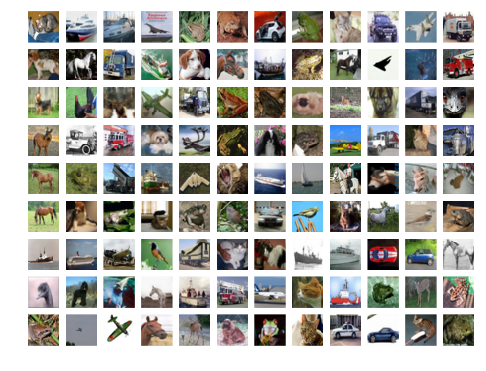

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(8, 6))
for i in range(0, 108):
    plt.subplot(9, 12, i+1)
    plt.axis('off')
    plt.imshow(imdeprocess(test_data[i]), interpolation='none')

Load the modules of Chainer

In [8]:
import six
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

In [9]:
gpuid = 0 # gpu device ID (cpu if this negative)
xp = cuda.cupy if gpuid >= 0 else np

Define the network architecture to reconstruct input images in the output layer

In [10]:
class AE(chainer.Chain):
    
    def __init__(self, n_in, n_h):
        super(AE, self).__init__(
            fc1 = L.Linear(n_in, n_h),
            fc2 = L.Linear(n_h, n_in)
        )
    
    def __call__(self, x, train=True):
        y = self.forward(x, train=train)
        self.loss = F.mean_squared_error(y, x)
        return self.loss

    def forward(self, x, train):
        self.h_data = x
        self.h_fc1 = F.dropout(
                        F.relu(self.fc1(self.h_data)),
                        train=train,
                        ratio=0.5)
        self.h_fc2 = self.fc2(self.h_fc1)
        return self.h_fc2

We'll crop 6x6-sized images from the dataset.  
`n_h` defines the number of units in the middle layer.

In [11]:
w = 6
n_in = 3 * w * w
n_h = 54
model = AE(n_in, n_h)
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))
if gpuid >= 0:
    cuda.get_device(gpuid).use()
    model.to_gpu()

In [12]:
def crop(images, size=w):
    cropped = []
    for im in images:
        i , j = np.random.randint(0, 32 - size, 2)
        cropped.append(im[ : , i: i + size, j: j + size])
    return np.asarray(cropped)

Initialized weights in the 1st layer

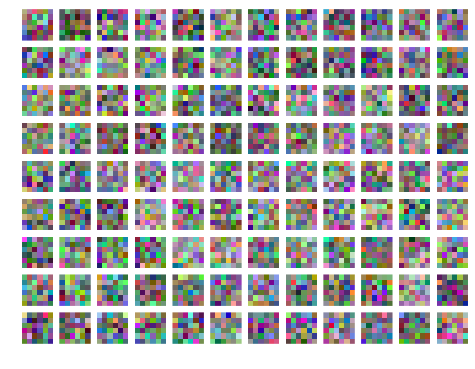

In [13]:
plt.figure(figsize=(8, 6))
for i in range(0, n_h):
    plt.subplot(9, 12, i + 1)
    fmap = np.array(model.fc1.W.data[i].tolist()).reshape(3, w, w)
    fmap -= fmap.min()
    fmap /= fmap.max()
    plt.imshow(fmap.transpose(1, 2, 0), interpolation='none')
    plt.axis('off')

Optimization

In [14]:
import sys

def test(x, batchsize=100):
    sum_loss = 0
    for i in six.moves.range(0, len(x), batchsize):
        x_batch = chainer.Variable(
            xp.asarray(
                crop(x[i:i + batchsize], w).reshape(batchsize, n_in)),
            volatile='auto')
        loss = model(x_batch, train=False)
        sum_loss += float(loss.data)
    sys.stderr.flush()
    return sum_loss * batchsize / len(x)

In [15]:
losses, test_its, test_losses = ([] for i in range(3))
loss = test(test_data)
test_its.append(len(losses))
test_losses.append(loss)
print ('test: loss={}'.format(str(loss)))

test: loss=1.5052243542671204


In [16]:
import progressbar as prg
n_epoch = 500
batchsize = 100
N = len(train_data)
np.random.seed(777)

# Learning loop
bar = prg.ProgressBar(max_value=n_epoch)
for epoch in six.moves.range(1, n_epoch + 1):
    # training
    perm = np.random.permutation(N)
    for i in six.moves.range(0, N, batchsize):
        x_batch = chainer.Variable(
            xp.asarray(
                crop(train_data[perm[i:i + batchsize]], w)
                .reshape(batchsize, n_in)),
            volatile='off')
        optimizer.update(model, x_batch)
        losses.append(float(model.loss.data))
    
    # evaluate
    loss = test(test_data)
    test_its.append(len(losses))
    test_losses.append(loss)
    bar.update(epoch)

100% (500 of 500) |########################| Elapsed Time: 0:16:21 ETA:  0:04:13

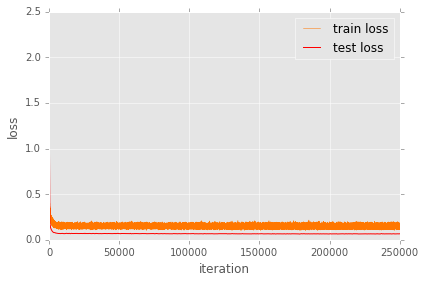

In [17]:
plt.plot(range(len(losses)), losses, ls='-', lw=0.5, color='#ff7700')
plt.plot(test_its, test_losses, 'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1, 1), framealpha=1)
plt.tight_layout()
plt.show()

Input image (left) and reconstructed output image (right)

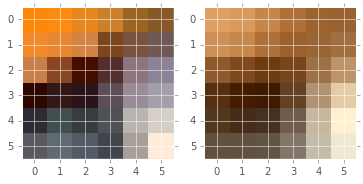

In [18]:
x = crop(test_data[0: 1])
x -= x.min()
x /= x.max()
plt.subplot(1, 2, 1)
plt.imshow(x[0].transpose((1, 2, 0)), interpolation='none')

xarray = chainer.Variable(xp.asarray(x), volatile='off')
outputs = model.forward(xarray, train=False)
x_hat = np.array(outputs.data.tolist()).reshape(1, 3, w, w)
x_hat -= x_hat.min()
x_hat /= x_hat.max()
plt.subplot(1, 2, 2)
plt.imshow(x_hat[0].transpose((1, 2, 0)), interpolation='none')

Learned weights in the 1st layer

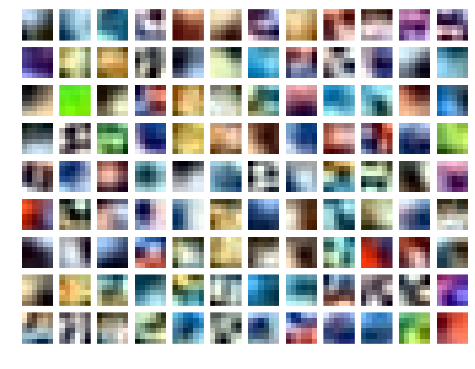

In [19]:
plt.figure(figsize=(8, 6))
for i in range(0, n_h):
    plt.subplot(9, 12, i + 1)
    fmap = np.array(model.fc1.W.data[i].tolist()).reshape(3, w, w)
    fmap -= fmap.min()
    fmap /= fmap.max()
    plt.imshow(fmap.transpose(1, 2, 0), interpolation='none')
    plt.axis('off')